In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [47]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [8]:
# create a base
Base = automap_base()

In [9]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()


['measurement', 'station']

In [10]:
# We can view all of the classes that automap found
inspector = inspect(engine)


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
Station = Base.classes.station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
title_df = pd.read_sql("SELECT prcp, max(date) as oldest_date FROM measurement", connection)
title_df

,prcp,oldest_date
0,0.0,2017-08-23


In [15]:
# Calculate the date 1 year ago from the last data point in the database
from sqlalchemy import cast, Date
from datetime import date
# this is some code i'm trying to get work without manually entering the date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# latest_date = session.query(cast(Measurement.date, Date)).order_by(Measurement.date.desc()).first() 
date_1_year = date.fromisoformat(latest_date)
date_1_yr_ago = date_1_year - dt.timedelta(days=365)
date_1_yr_ago
# latest_date[0].split('-')

datetime.date(2016, 8, 23)

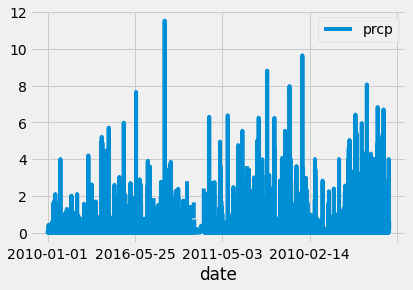

In [26]:
# Perform a query to retrieve the date and precipitation scores
prcp_df = pd.read_sql("SELECT date, prcp FROM measurement", connection)


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df.set_index('date', inplace = True)

# Sort the dataframe by date
prcp_df.sort_values(by=['date'])
prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_table = prcp_df.agg({"prcp":["mean","median","var","std","sem"]})
summary_table

,prcp
mean,0.160644
median,0.010000
var,0.219723
std,0.468746
sem,0.003484


In [28]:
# Design a query to show how many stations are available in this dataset?
title_df = pd.read_sql("SELECT DISTINCT station FROM station", connection)
len(title_df)

9

In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
measurement = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
measurement

# list the number of stations for an internal loop

# loop through the full measurement set to count the number of stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps = session.query(Measurement.station, func.min(Measurement.tobs),\
                            func.max(Measurement.tobs), func.round(func.avg(Measurement.tobs),2)).\
                            filter(Measurement.station=='USC00519281').all()
temps


[('USC00519281', 54.0, 85.0, 71.66)]

(array([ 5.,  7.,  7., 12., 27., 41., 40., 57., 66., 53., 29.,  8.]),
 array([59., 61., 63., 65., 67., 69., 71., 73., 75., 77., 79., 81., 83.]),
 <a list of 12 Patch objects>)

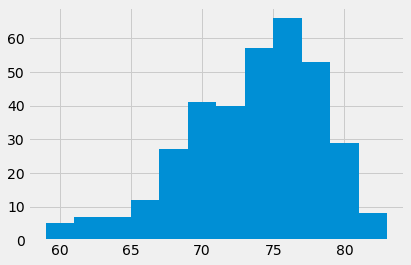

In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
high_stn = session.query(Measurement.tobs).\
            filter(Measurement.station=='USC00519281', Measurement.date >= prev_year).all()
high_stn = np.ravel(high_stn)
# high_stn

plt.hist(high_stn, bins=12)

Text(0.5, -1.340000000000014, 'Temperature')

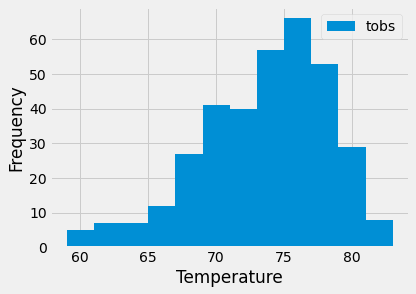

In [35]:
# This is the same reult as the code above, but i used a different method to get there.
# I was practicing the two different methods

prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
results
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

# Flask: see VS Code for the full code

In [73]:
# I practiced many of the things in my python code here.  this was to create the
# the first part of the flask project /precipitation
station_df = pd.read_sql("SELECT DISTINCT station FROM station", connection)
station_dict_list = station_df.set_index('station').T.to_dict('records')
# return jsonify(station_dict_list)

In [46]:
# this was to create the second part of the flask project, /tobs
stations = session.query(Station.station).distinct
stations

<bound method Query.distinct of <sqlalchemy.orm.query.Query object at 0x000001CFB28BF5E0>>

In [48]:
# this was to create the third part of the flask project, /tobs
most_active_df = pd.read_sql("SELECT tobs, date FROM measurement where station = 'USC00519281'", connection)
active_dict_list = most_active_df.set_index('date').T.to_dict('records')
active_dict_list

[{'2010-01-01': 70.0,
  '2010-01-02': 62.0,
  '2010-01-03': 74.0,
  '2010-01-04': 75.0,
  '2010-01-05': 74.0,
  '2010-01-06': 76.0,
  '2010-01-07': 69.0,
  '2010-01-08': 66.0,
  '2010-01-09': 70.0,
  '2010-01-10': 75.0,
  '2010-01-11': 64.0,
  '2010-01-12': 60.0,
  '2010-01-13': 61.0,
  '2010-01-14': 68.0,
  '2010-01-15': 64.0,
  '2010-01-16': 66.0,
  '2010-01-17': 67.0,
  '2010-01-18': 70.0,
  '2010-01-19': 67.0,
  '2010-01-20': 67.0,
  '2010-01-21': 69.0,
  '2010-01-22': 60.0,
  '2010-01-23': 75.0,
  '2010-01-24': 75.0,
  '2010-01-25': 65.0,
  '2010-01-26': 75.0,
  '2010-01-27': 69.0,
  '2010-01-28': 67.0,
  '2010-01-29': 66.0,
  '2010-01-30': 69.0,
  '2010-01-31': 72.0,
  '2010-02-01': 67.0,
  '2010-02-02': 65.0,
  '2010-02-03': 64.0,
  '2010-02-04': 67.0,
  '2010-02-05': 67.0,
  '2010-02-06': 68.0,
  '2010-02-07': 69.0,
  '2010-02-08': 66.0,
  '2010-02-09': 69.0,
  '2010-02-10': 61.0,
  '2010-02-11': 71.0,
  '2010-02-12': 70.0,
  '2010-02-13': 70.0,
  '2010-02-14': 66.0,
  '2010-02

In [72]:
# this was to create the last part /<start> and /<start>/<end>
start = dt.datetime(2012, 9, 17)
start_list = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs),\
                          func.max(Measurement.tobs)).filter(Measurement.date>=start).all()
start_list 
# start_list

[('2017-05-23', 53.0, 73.48813447593935, 87.0)]

## Bonus Challenge Assignment - Temp Analysis I

In [ ]:
# This part of the bonus challenge asks us to compare temperatures in June versus December.
# I will begin with separating the two different data sets for the different months.
# I will then create a function to return the average values across the two months.
# Finally, it is appropriate to use a 2-sample t-test to see if there is statistical
# difference between the means.  2-sample is appropriate because they are disparate datasets
# as opposed to 1-sample which uses a sample of a single dataset.

In [45]:
june_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
dec_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()
dec_temps

[(76.0),
 (74.0),
 (74.0),
 (64.0),
 (64.0),
 (67.0),
 (77.0),
 (66.0),
 (69.0),
 (68.0),
 (68.0),
 (71.0),
 (74.0),
 (67.0),
 (66.0),
 (69.0),
 (71.0),
 (70.0),
 (70.0),
 (74.0),
 (74.0),
 (71.0),
 (75.0),
 (75.0),
 (72.0),
 (69.0),
 (68.0),
 (73.0),
 (74.0),
 (73.0),
 (73.0),
 (73.0),
 (73.0),
 (71.0),
 (73.0),
 (73.0),
 (77.0),
 (72.0),
 (71.0),
 (73.0),
 (70.0),
 (73.0),
 (69.0),
 (74.0),
 (72.0),
 (71.0),
 (72.0),
 (72.0),
 (70.0),
 (73.0),
 (73.0),
 (72.0),
 (73.0),
 (73.0),
 (72.0),
 (63.0),
 (65.0),
 (71.0),
 (76.0),
 (70.0),
 (76.0),
 (69.0),
 (69.0),
 (69.0),
 (74.0),
 (76.0),
 (74.0),
 (73.0),
 (73.0),
 (74.0),
 (73.0),
 (73.0),
 (73.0),
 (74.0),
 (74.0),
 (71.0),
 (73.0),
 (72.0),
 (64.0),
 (66.0),
 (73.0),
 (72.0),
 (65.0),
 (64.0),
 (69.0),
 (68.0),
 (77.0),
 (71.0),
 (71.0),
 (69.0),
 (68.0),
 (68.0),
 (69.0),
 (70.0),
 (72.0),
 (76.0),
 (75.0),
 (69.0),
 (71.0),
 (71.0),
 (71.0),
 (68.0),
 (65.0),
 (70.0),
 (69.0),
 (69.0),
 (71.0),
 (67.0),
 (73.0),
 (74.0),
 (73.0),
 

In [51]:
# This function returns the monthly average temperature for June and December
def monthly_normals(month):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.avg(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m", Measurement.date) == month).all()
    
print(monthly_normals("06"))
print(monthly_normals("12"))

[(74.94411764705882,)]
[(71.04152933421226,)]


In [49]:
# create graphs showing the 2 sets of data
def gendata(loc1=0, loc2=0):
    population1 = stats.norm.rvs(loc=loc1, size=50, random_state=0)  #not sample data but 2 diff data sets
    population2 = stats.norm.rvs(loc=loc2, size=45, random_state=42)

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population1)), population1, label="population1")
    plt.scatter(range(len(population2)), population2, label="population2")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(population1, 10, density=True, alpha=0.7, label="population1")
    plt.hist(population2, 10, density=True, alpha=0.7, label="population2")
    plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return population1, population2

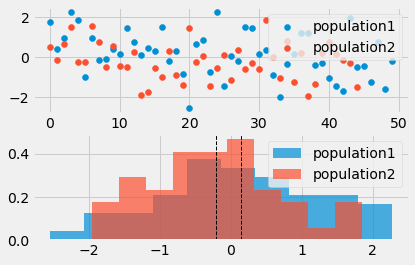

In [50]:
june_temps, dec_temps = gendata()

In [48]:
# Run the 2-sample t-test.  Results show there is no signifant diff and the std dev is very low.
# In other words, the t-test can be trusted
stats.ttest_ind(june_temps, dec_temps, equal_var=False)

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

## Bonus Challenge Assignment - Temp Analysis II

In [60]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs), 2), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [61]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# This is a calculation not using the actual dates: calc_temps(date_1_yr_ago, date.fromisoformat(latest_date))
calc_temps('2017-02-28', '2017-03-05')


[(64.0, 72.03, 78.0)]

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title



# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
